<a href="https://colab.research.google.com/github/ELSOUDY2030/Instance-Segmentation/blob/main/Instance_Segmentation_Tooth_Dentistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44089 sha256=aeb6567830a2abb2c48f5185ba16dd07f8bdba80fc42dff102d77c7efab1e8e6
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2023.8.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
distributed 2023.8.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.7.2 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.

In [ ]:
!pip install kaggle


In [ ]:
import os
import cv2
import glob
import warnings
import detectron2
import numpy as np
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d mohammednomer/dentistry-vbril

  0% 0.00/5.46M [00:00<?, ?B/s]
100% 5.46M/5.46M [00:00<00:00, 64.8MB/s]


In [ ]:
!unzip dentistry-vbril.zip

Archive:  dentistry-vbril.zip
  inflating: train/0000001_png_jpg.rf.c6a4a70a04910135d4d36cf27ec29d2d.jpg  
  inflating: train/0000002_png_jpg.rf.4285bcf8f5a839c9721acb59e44713ed.jpg  
  inflating: train/0000003_png_jpg.rf.6f3f0d829187cde77c01a792dd8c49d1.jpg  
  inflating: train/0000004_png_jpg.rf.fcb02f49326b23616275be1c96fdcbd8.jpg  
  inflating: train/0000006_png_jpg.rf.6bab0b75179ed0421439d2b330324c38.jpg  
  inflating: train/0000007_png_jpg.rf.909154d3034aa36b52f89c516d02cc70.jpg  
  inflating: train/0000009_png_jpg.rf.bd3765379a79d44f2323fea7b4692bc0.jpg  
  inflating: train/0000010_png_jpg.rf.b0303eaa227b63f7186995a5e79ce4e8.jpg  
  inflating: train/0000012_png_jpg.rf.474657e33ffcd1a6e1651e8653b38537.jpg  
  inflating: train/0000013_png_jpg.rf.96f72f438485e4623a1e6e0986057332.jpg  
  inflating: train/0000014_png_jpg.rf.3d29caf165aa8a4145df12f53cf5125a.jpg  
  inflating: train/0000015_png_jpg.rf.7550b426b0f25ddfc258726380aa1e5c.jpg  
  inflating: train/0000016_png_jpg.rf.16f9c926

In [ ]:
warnings.filterwarnings(action='ignore', category=FutureWarning)
register_coco_instances('tooth_train', {}, '/content/train/_annotations.coco.json', '/content/train')
register_coco_instances('tooth_val', {}, '/content/valid/_annotations.coco.json', '/content/valid')
train_metadata =  MetadataCatalog.get('tooth_train')
train_dataset = DatasetCatalog.get('tooth_train')


In [ ]:
from google.colab import drive
from keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("tooth_train",)
cfg.DATASETS.TEST = ("tooth_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Model_share/my_output_folder/model_0054999.pth'
#model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 60000 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (400,800,1200,1600)
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this  dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 36  # only has one class (damage) + 1
# cfg.MODEL.RETINANET.NUM_CLASSES = 36 # only has one class (damage) + 1
cfg.TEST.EVAL_PERIOD = 250



# Clear any logs from previous runs
#TODO add timestamp to logs
#!rm -rf cfg.OUTPUT_DIR

cfg.OUTPUT_DIR = "/content/drive/MyDrive/Model_share/my_output_folder"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/07 23:08:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/07 23:08:55 d2.utils.events]:  eta: 0:56:53  iter: 55019  total_loss: 1.12  loss_cls: 0.3156  loss_box_reg: 0.3864  loss_mask: 0.2523  loss_rpn_cls: 0.009398  loss_rpn_loc: 0.1398    time: 0.6646  last_time: 0.7135  data_time: 0.0308  last_data_time: 0.0178   lr: 0.0001  max_mem: 3099M
[09/07 23:09:09 d2.utils.events]:  eta: 0:57:21  iter: 55039  total_loss: 1.119  loss_cls: 0.3202  loss_box_reg: 0.3694  loss_mask: 0.249  loss_rpn_cls: 0.00732  loss_rpn_loc: 0.1376    time: 0.6747  last_time: 0.7364  data_time: 0.0262  last_data_time: 0.0318   lr: 0.0001  max_mem: 3099M
[09/07 23:09:23 d2.utils.events]:  eta: 0:57:07  iter: 55059  total_loss: 1.071  loss_cls: 0.3136  loss_box_reg: 0.3772  loss_mask: 0.239  loss_rpn_cls: 0.007968  loss_rpn_loc: 0.1335    time: 0.6748  last_time: 0.6625  data_time: 0.0250  last_data_time: 0.0267   lr: 0.0001  max_mem: 3099M
[09/07 23:09:36 d2.utils.events]:  eta: 0:57:01  iter: 55079  total_loss: 1.127  loss_cls: 0.3389  loss_box_reg: 0.3939  loss_ma

In [ ]:
import detectron2
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
import cv2
import matplotlib.pyplot as plt

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Model_share/my_output_folder/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 36

model = DefaultPredictor(cfg)


In [ ]:
img = cv2.imread('/content/train/0000004_png_jpg.rf.fcb02f49326b23616275be1c96fdcbd8.jpg')


In [ ]:
out = model(img)

In [ ]:
instances = out['instances']
instances = instances.to("cpu")

In [ ]:

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

In [ ]:
v = Visualizer(img[:,:,::-1], metadata, scale = 10)
output = v.draw_instance_predictions(instances)

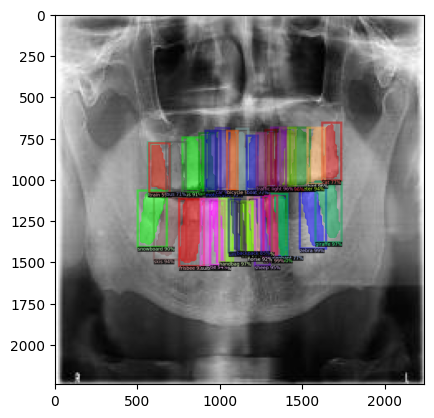

In [ ]:
plt.imshow( output.get_image()[:, :, ::-1])